<a href="https://www.kaggle.com/code/godsonajodo/cs164-svm-parameter-tuning-with-optimization?scriptVersionId=214078489" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.4.* 

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.6/126.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.9/810.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.

In [3]:
!pip install scikit-optimize

In [4]:
# Import Necessary Libraries
from cuml import SVC
from cuml.preprocessing import StandardScaler
from cuml.model_selection import GridSearchCV as cumlGridSearchCV
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split  # Only scikit-learn's train_test_split is used
import time
import traceback


<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.ChunkedArray size changed, may indicate binary incompatibility. Expected 64 from C header, got 72 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib._Tabular size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Table size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedInputStream size changed, may indicate binary incompatibility. Expected 

In [5]:

def visualize_samples(X, y, predictions=None, sample_size=10, title_prefix="Sample"):
    """
    Visualizes a sample of images and their corresponding labels or predictions.
    
    Parameters:
    - X (cupy.ndarray): Array of image data.
    - y (cupy.ndarray or numpy.ndarray): Array of labels or predictions.
    - predictions (cupy.ndarray or numpy.ndarray, optional): Array of predictions to compare with true labels.
    - sample_size (int): Number of samples to visualize.
    - title_prefix (str): Prefix for the plot titles.
    """
    num_samples = X.shape[0]
    
    if sample_size > num_samples:
        sample_size = num_samples
        print(f"Warning: sample_size was greater than the actual data size. Visualizing {sample_size} samples.")
    
    rand_indices = random.sample(range(num_samples), sample_size)
    images = X[rand_indices]
    labels = y[rand_indices]
    
    plt.figure(figsize=(15, 12))
    
    for i in range(sample_size):
        plt.subplot(2, 5, i + 1)
        plt.axis('off')
        image = cp.asnumpy(images[i]).reshape(28, 28)
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        if predictions is not None:
            true_label = int(labels[i])
            pred_label = int(predictions[i])
            title = f"True: {true_label}\nPred: {pred_label}"
        else:
            title = f"Label: {int(labels[i])}"
        plt.title(title, fontsize=8)
    
    plt.tight_layout()
    plt.show()


In [6]:

def load_and_preprocess_data():
    """
    Loads the MNIST dataset, splits it into training and testing sets, and scales the features.
    
    Returns:
    - X_train_scaled (cupy.ndarray): Scaled training features.
    - X_test_scaled (cupy.ndarray): Scaled testing features.
    - y_train (cupy.ndarray): Training labels.
    - y_test (cupy.ndarray): Testing labels.
    """
    # Load MNIST Dataset
    print("Loading MNIST dataset...")
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist["data"], mnist["target"]
    y = y.astype(int)
    
    # Split into Training and Testing Sets
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42, stratify=y
    )
    
    # Convert to CuPy Arrays with Appropriate dtypes
    print("Converting data to CuPy arrays...")
    X_train = cp.asarray(X_train, dtype=cp.float32)
    X_test = cp.asarray(X_test, dtype=cp.float32)
    y_train = cp.asarray(y_train, dtype=cp.int32)
    y_test = cp.asarray(y_test, dtype=cp.int32)
    
    # Scale Features
    print("Scaling features with StandardScaler...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test


In [7]:

import seaborn as sns

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap.

    Parameters:
    - cm (numpy.ndarray): Confusion matrix.
    - title (str): Title for the plot.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def evaluate_model(model, X_test, y_test, title="Model Evaluation"):
    """
    Evaluates the trained model on the test set and prints classification metrics.
    Additionally, displays the confusion matrix as a heatmap.

    Parameters:
    - model (cuml.svm.SVC or sklearn.svm.SVC): Trained SVM model.
    - X_test (cupy.ndarray): Scaled testing features.
    - y_test (cupy.ndarray): Testing labels.
    - title (str): Title for the evaluation output.

    Returns:
    - None
    """
    try:
        print(f"Evaluating {title}...")
        y_pred = model.predict(X_test)
        
        # Convert CuPy arrays to NumPy for evaluation and visualization
        y_test_np = cp.asnumpy(y_test)
        y_pred_np = cp.asnumpy(y_pred)
        # X_test_np = cp.asnumpy(X_test)  # Not used here
        
        # Classification Report
        print(f"{title} Classification Report:\n{metrics.classification_report(y_test_np, y_pred_np)}")
        
        # Confusion Matrix
        cm = metrics.confusion_matrix(y_test_np, y_pred_np)
        print(f"{title} Confusion Matrix:\n{cm}")
        
        # Plot Confusion Matrix as Heatmap
        plot_confusion_matrix(cm, title=f"{title} Confusion Matrix Heatmap")
        
        # Visualize Some Predictions
        visualize_samples(X_test, y_pred, sample_size=10, title_prefix=title)
    except Exception as e:
        print("Error in evaluate_model:")
        traceback.print_exc()
        raise


In [8]:
def train_baseline_model_linear(X_train, y_train):
    """
    Trains a baseline SVM model with default hyperparameters using the linear kernel
    
    Parameters:
    - X_train (cupy.ndarray): Scaled training features.
    - y_train (cupy.ndarray): Training labels.
    
    Returns:
    - model (cuml.svm.SVC): Trained SVM model.
    """
    print("Training baseline SVM model with default hyperparameters using the linear kernel")
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    print("Baseline model training complete.\n")
    return model

In [9]:

def train_baseline_model_rbf(X_train, y_train):
    """
    Trains a baseline SVM model with default hyperparameters using rbf
    
    Parameters:
    - X_train (cupy.ndarray): Scaled training features.
    - y_train (cupy.ndarray): Training labels.
    
    Returns:
    - model (cuml.svm.SVC): Trained SVM model.
    """
    print("Training baseline SVM model with default hyperparameters using rbf")
    model = SVC(kernel='rbf', random_state=42)
    model.fit(X_train, y_train)
    print("Baseline model training complete.\n")
    return model


In [10]:

def perform_grid_search(X_train, y_train):
    """
    Performs hyperparameter tuning using GridSearchCV.
    
    Parameters:
    - X_train (cupy.ndarray): Scaled training features.
    - y_train (cupy.ndarray): Training labels.
    
    Returns:
    - best_model (cuml.svm.SVC): Best SVM model found by GridSearchCV.
    - grid_search (cuml.model_selection.GridSearchCV): GridSearchCV object containing results.
    """
    print("Starting hyperparameter tuning with GridSearchCV...")
    
    # Define Parameter Grid
    param_grid = {
        'kernel': ['rbf'],
        'C': [5, 10],
        'gamma': [1e-2, 1e-3, 1e-4],
    }
    
    # Initialize GridSearchCV
    grid_search = cumlGridSearchCV(
        estimator=SVC(random_state=42),
        param_grid=param_grid,
        cv=3,
        verbose=2
    )
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    print("GridSearchCV completed.")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}\n")
    
    return grid_search.best_estimator_, grid_search


Loading MNIST dataset...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Splitting data into training and testing sets...
Converting data to CuPy arrays...
Scaling features with StandardScaler...


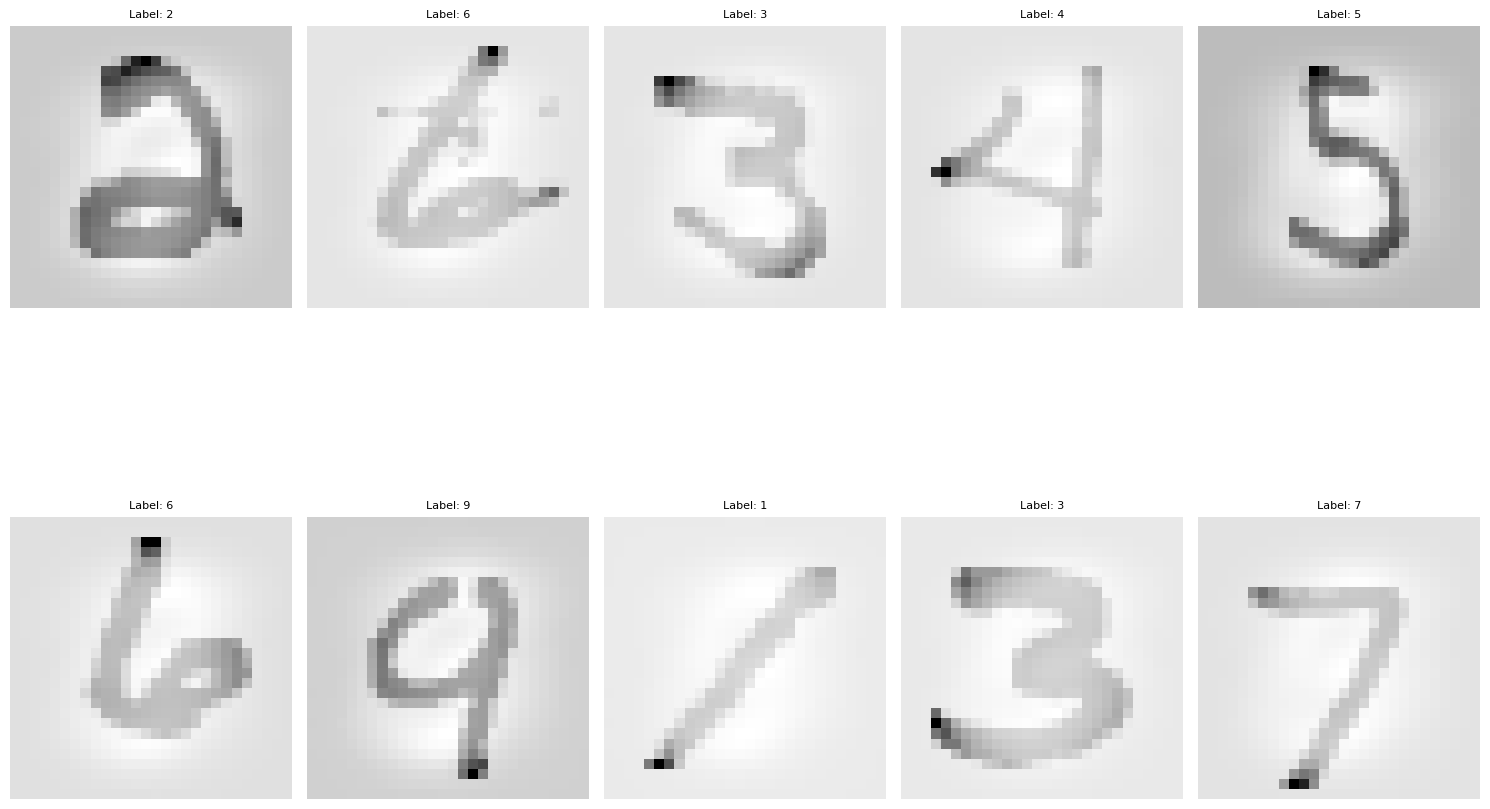

Training baseline SVM model with default hyperparameters using the linear kernel
[W] [22:46:02.119112] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
Baseline model training complete.

Evaluating Baseline Model...
Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       690
           1       0.96      0.98      0.97       788
           2       0.91      0.91      0.91       699
           3       0.90      0.89      0.90       714
           4       0.94      0.93      0.93       682
           5       0.89      0.88      0.89       631
           6       0.96      0.95      0.96       688
           7       0.93      0.94      0.94       729
           8       0.89      0.89      0.89       683
           9       0.91      0.91      0.91       696

    accuracy                           0

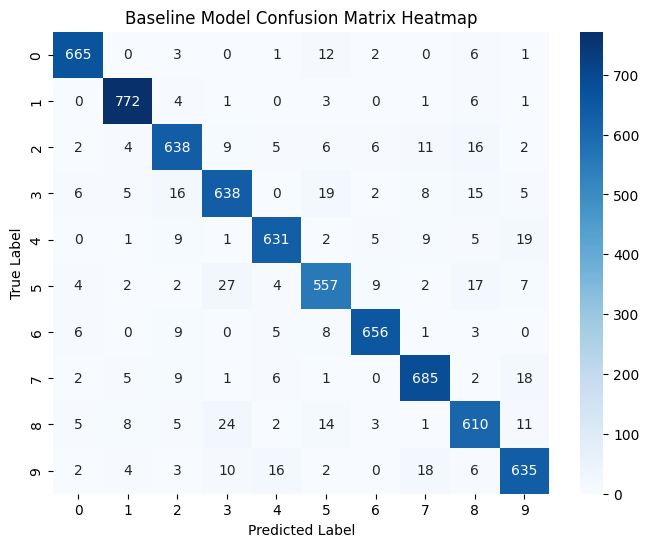

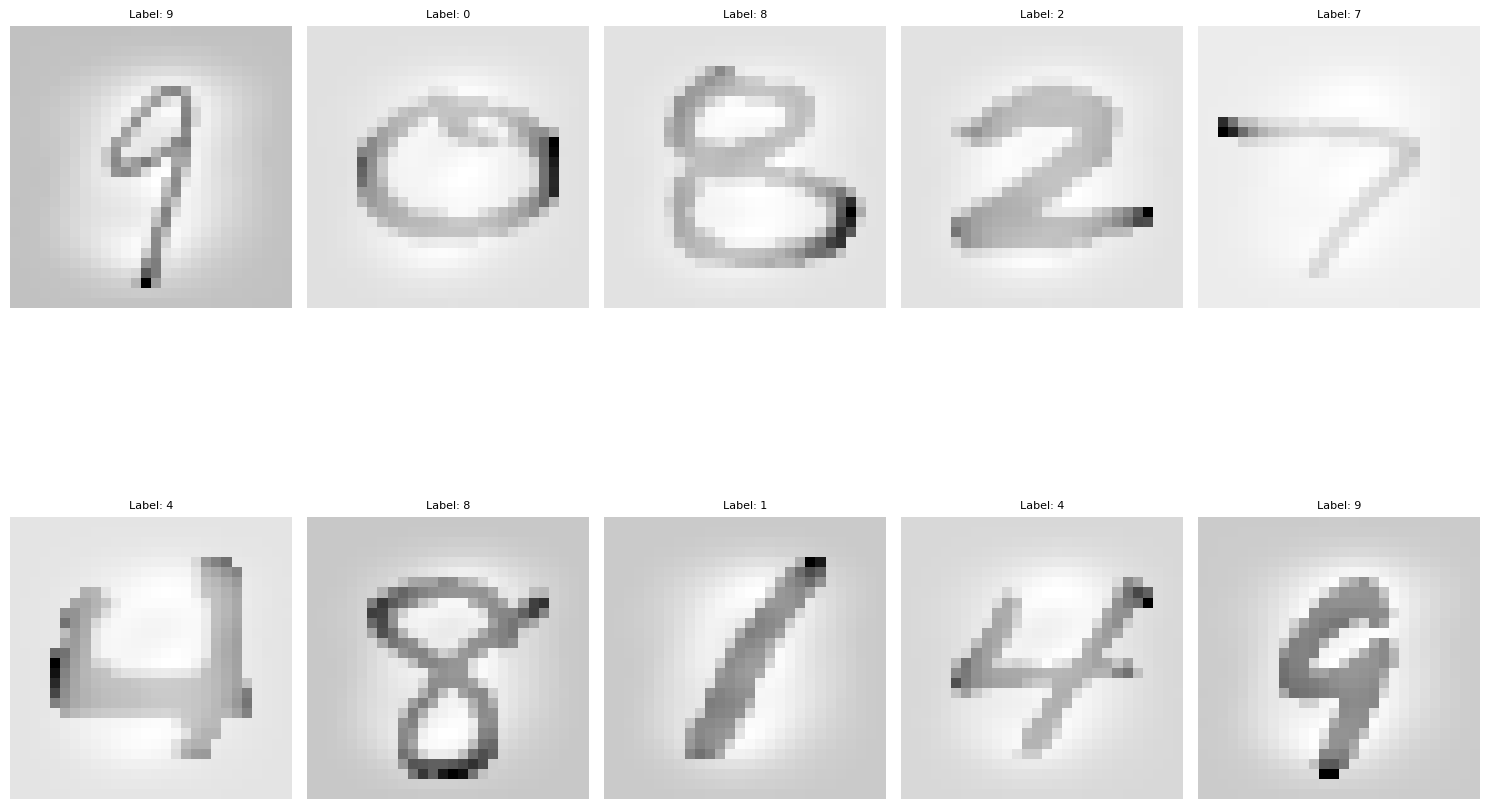

Training baseline SVM model with default hyperparameters using rbf
Baseline model training complete.

Evaluating Baseline Model...
Baseline Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       690
           1       0.98      0.99      0.99       788
           2       0.98      0.97      0.97       699
           3       0.97      0.96      0.96       714
           4       0.98      0.96      0.97       682
           5       0.98      0.95      0.96       631
           6       0.97      0.99      0.98       688
           7       0.94      0.97      0.95       729
           8       0.97      0.96      0.96       683
           9       0.95      0.95      0.95       696

    accuracy                           0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000

Baseline Model Confusion Matrix:
[[681   1   1   0   1   0   2   1   3  

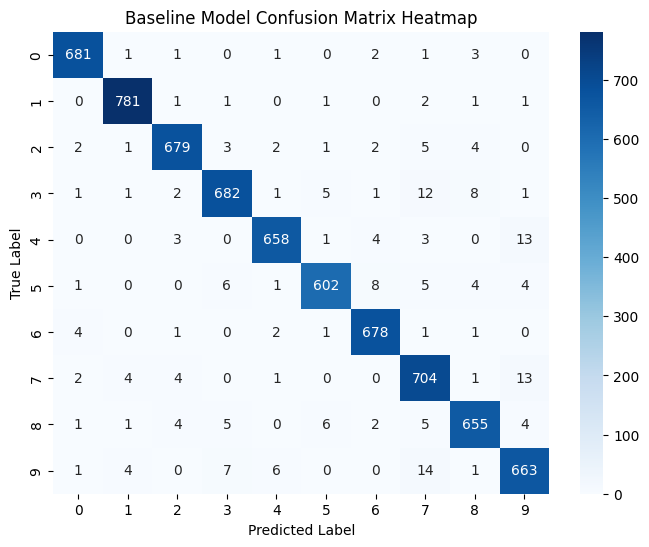

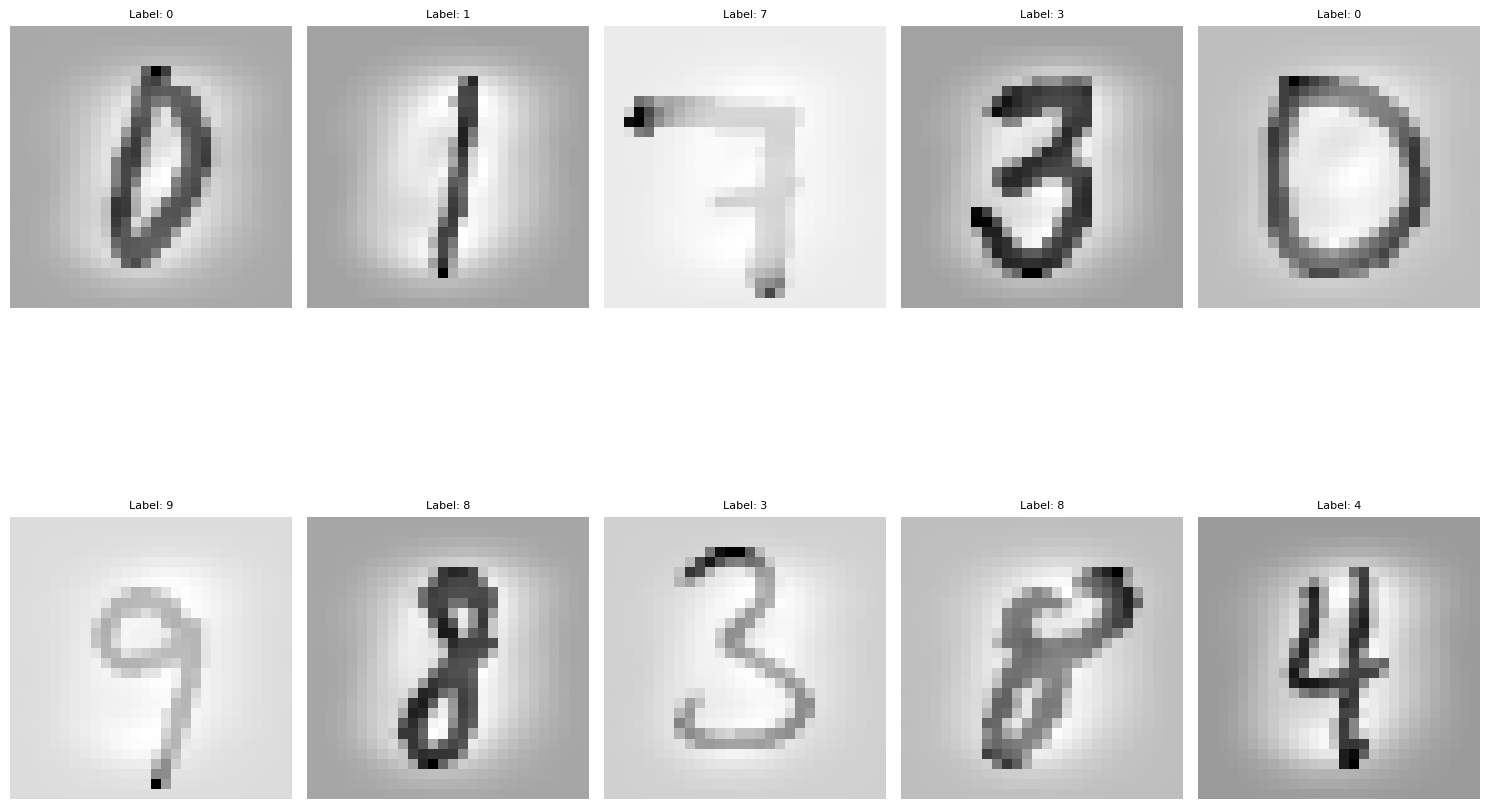

Starting hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ........................C=5, gamma=0.01, kernel=rbf; total time=  13.1s
[CV] END ........................C=5, gamma=0.01, kernel=rbf; total time=  13.1s
[CV] END ........................C=5, gamma=0.01, kernel=rbf; total time=  13.3s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=   5.6s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=   5.6s
[CV] END .......................C=5, gamma=0.001, kernel=rbf; total time=   5.6s
[CV] END ......................C=5, gamma=0.0001, kernel=rbf; total time=   5.3s
[CV] END ......................C=5, gamma=0.0001, kernel=rbf; total time=   5.7s
[CV] END ......................C=5, gamma=0.0001, kernel=rbf; total time=   5.3s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=  13.7s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=  13.

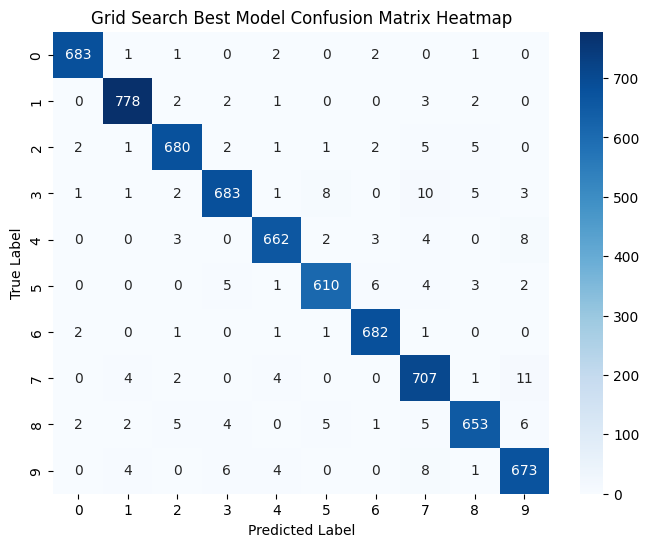

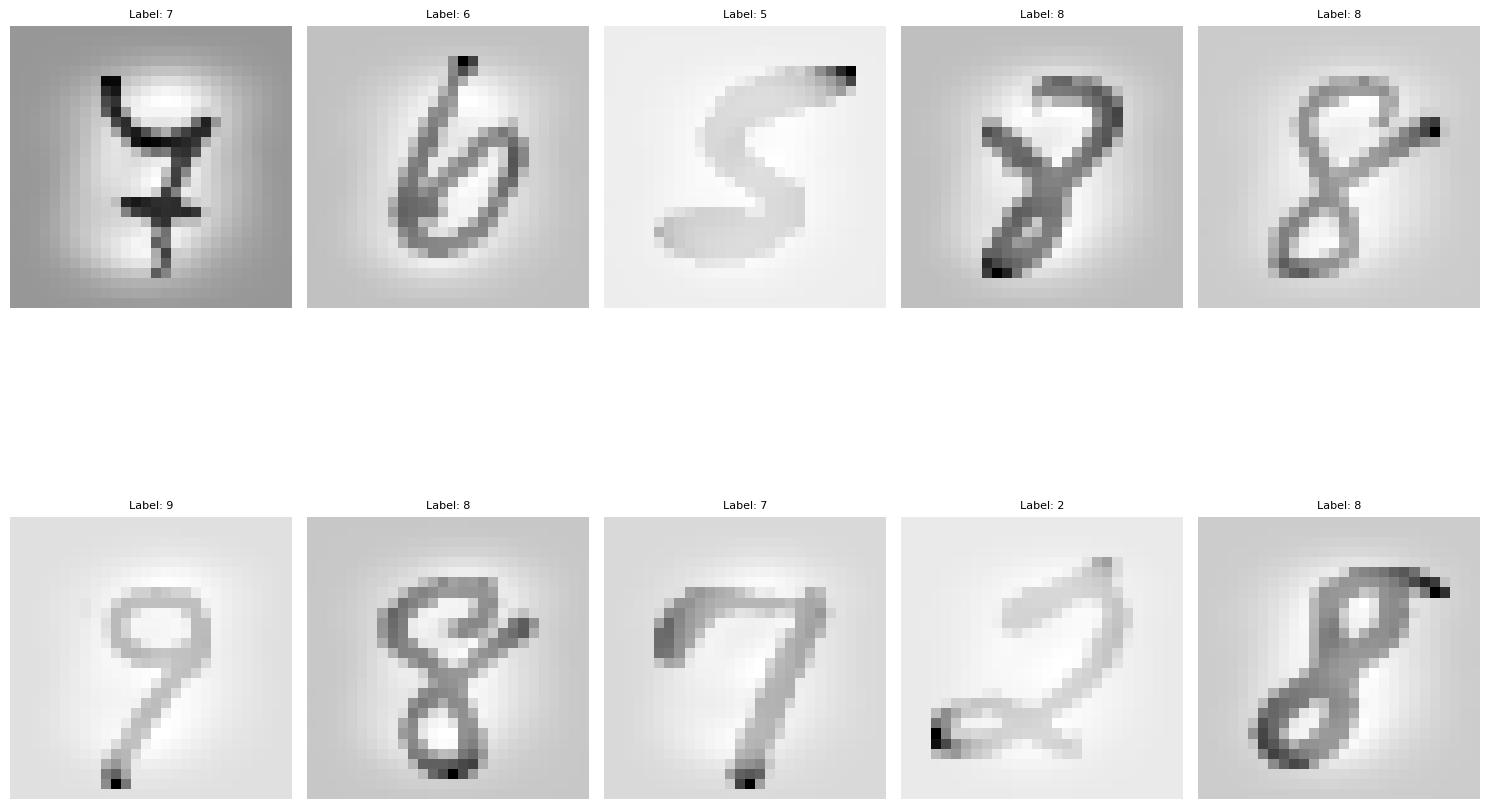

Total Execution Time: 264.66 seconds


In [11]:

def main():
    """
    Main function to orchestrate the SVM training, hyperparameter tuning, and evaluation.
    """
    start_time = time.time()
    
    # Load and Preprocess Data
    X_train_scaled, X_test_scaled, y_train, y_test = load_and_preprocess_data()
    
    # Visualize Some Training Samples
    visualize_samples(X_train_scaled, y_train, sample_size=10, title_prefix="Training Sample")
    
    X_train_cpu = cp.asnumpy(X_train_scaled)
    y_train_cpu = cp.asnumpy(y_train)

    

    
    # Train Baseline Model using Linear kernel
    baseline_model_linear = train_baseline_model_linear(X_train_cpu, y_train_cpu)
    
    # Evaluate Baseline Model
    evaluate_model(baseline_model_linear, X_test_scaled, y_test, title="Baseline Model")

    # Train Baseline Model using rbf kernel
    baseline_model_rbf = train_baseline_model_rbf(X_train_cpu, y_train_cpu)
    
    # Evaluate Baseline Model
    evaluate_model(baseline_model_rbf, X_test_scaled, y_test, title="Baseline Model")
    
    # Perform Hyperparameter Tuning with GridSearchCV
    best_model, grid_search = perform_grid_search(X_train_cpu, y_train_cpu)
    
    # Evaluate Best Model from Grid Search
    evaluate_model(best_model, X_test_scaled, y_test, title="Grid Search Best Model")
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total Execution Time: {total_time:.2f} seconds")

if __name__ == "__main__":
    main()


In [12]:
def perform_bayesian_optimization(X_train, y_train):
    """
    Performs hyperparameter tuning using Bayesian optimization with Optuna.
    
    Parameters:
    - X_train (cupy.ndarray): Scaled training features.
    - y_train (cupy.ndarray): Training labels.
    
    Returns:
    - best_model (cuml.svm.SVC): Best SVM model found by Bayesian optimization.
    - study (optuna.study.Study): Optuna study object containing results.
    """
    print("Starting hyperparameter tuning with Bayesian Optimization (Optuna)...")
    
    def objective(trial):
        C = trial.suggest_float('C', 1, 20)
        gamma = trial.suggest_float('gamma', 1e-4, 1e-2, log=True)
        
        model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_train)
        accuracy = metrics.accuracy_score(cp.asnumpy(y_train), cp.asnumpy(y_pred))
        return accuracy
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    best_params = study.best_params
    best_model = SVC(kernel='rbf', random_state=42, **best_params)
    best_model.fit(X_train, y_train)
    
    print("Bayesian Optimization (Optuna) completed.")
    print(f"Best Parameters: {best_params}")
    print(f"Best Score: {study.best_value}\\n")
    
    return best_model, study

def perform_random_search(X_train, y_train, n_iter=10):
    """
    Performs hyperparameter tuning using Random Search with skopt.
    
    Parameters:
    - X_train (cupy.ndarray): Scaled training features.
    - y_train (cupy.ndarray): Training labels.
    - n_iter (int): Number of random combinations to try.
    
    Returns:
    - best_model (cuml.svm.SVC): Best SVM model found by Random Search.
    - random_search (skopt.BayesSearchCV): RandomSearchCV object containing results.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    print("Starting hyperparameter tuning with Random Search...")

    search_spaces = {
        'C': Real(1, 20),
        'gamma': Real(1e-4, 1e-2, prior='log-uniform'),
    }
    
    random_search = BayesSearchCV(
        SVC(kernel='rbf', random_state=42),
        search_spaces,
        n_iter=n_iter,
        cv=3,
        n_jobs=-1
    )
    
    random_search.fit(cp.asnumpy(X_train), cp.asnumpy(y_train))
    
    print("Random Search completed.")
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Score: {random_search.best_score_}\\n")

    best_model = SVC(kernel='rbf', random_state=42, **random_search.best_params_)
    best_model.fit(X_train, y_train)



    
    
    return best_model, random_search


In [13]:
!pip install optuna

Loading MNIST dataset...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Splitting data into training and testing sets...
Converting data to CuPy arrays...
Scaling features with StandardScaler...


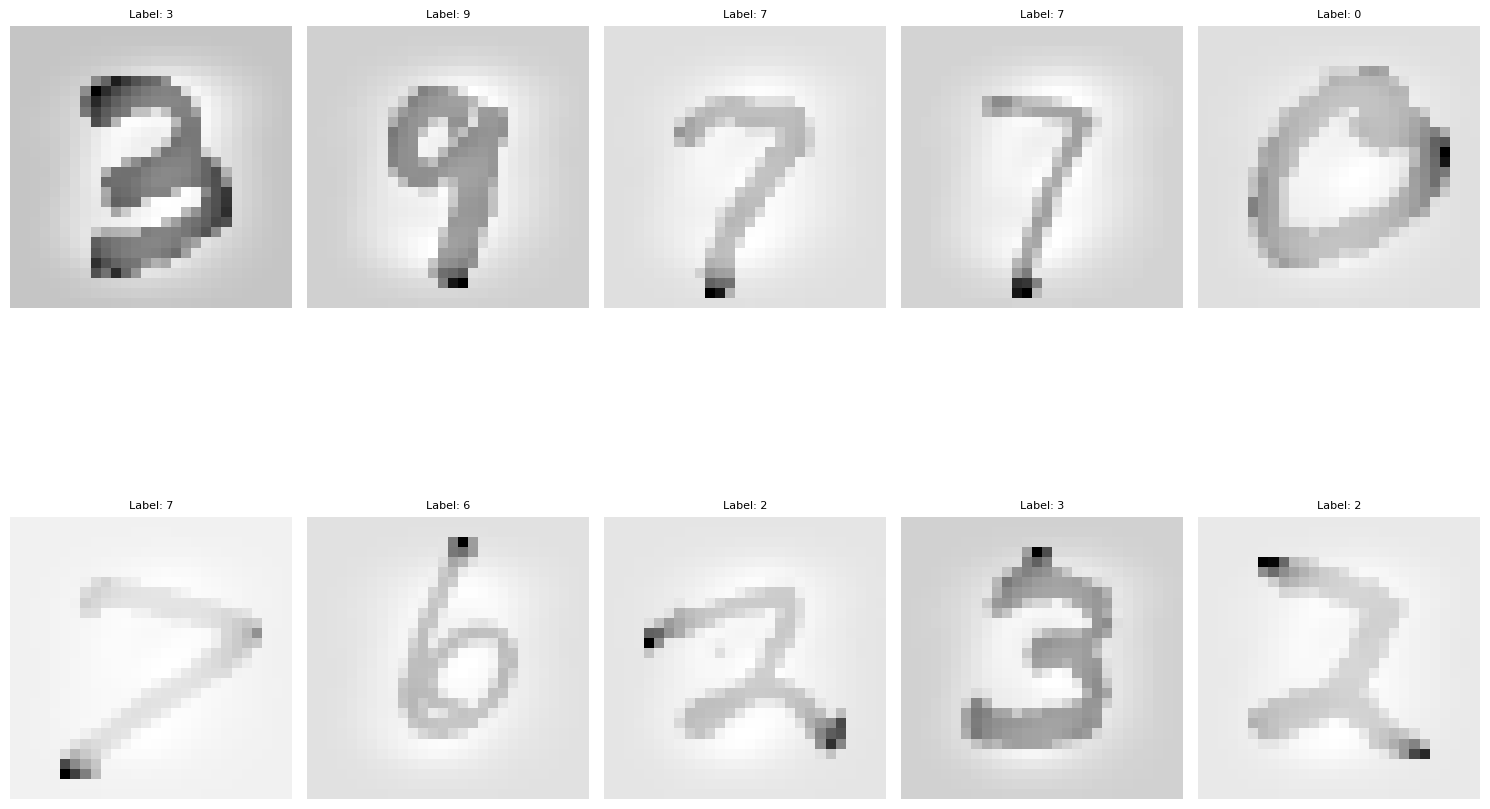

[I 2024-12-20 22:50:10,367] A new study created in memory with name: no-name-fbb8207b-b0b4-48f5-bc9d-db107164fa0b


Starting hyperparameter tuning with Bayesian Optimization (Optuna)...


[I 2024-12-20 22:50:22,006] Trial 0 finished with value: 0.9782698412698413 and parameters: {'C': 19.70015042165001, 'gamma': 0.00015458993729570539}. Best is trial 0 with value: 0.9782698412698413.
[I 2024-12-20 22:50:33,107] Trial 1 finished with value: 0.9772857142857143 and parameters: {'C': 11.713738984507922, 'gamma': 0.00019464633936470827}. Best is trial 0 with value: 0.9782698412698413.
[I 2024-12-20 22:50:45,585] Trial 2 finished with value: 0.9996190476190476 and parameters: {'C': 19.55727785419959, 'gamma': 0.0010737731221633405}. Best is trial 2 with value: 0.9996190476190476.
[I 2024-12-20 22:50:56,910] Trial 3 finished with value: 0.9902857142857143 and parameters: {'C': 8.068650557845638, 'gamma': 0.0005061737770917316}. Best is trial 2 with value: 0.9996190476190476.
[I 2024-12-20 22:51:08,469] Trial 4 finished with value: 0.9957460317460317 and parameters: {'C': 13.900015554055402, 'gamma': 0.0005612319021153071}. Best is trial 2 with value: 0.9996190476190476.
[I 202

Bayesian Optimization (Optuna) completed.
Best Parameters: {'C': 5.066464500082426, 'gamma': 0.0070343585539419835}
Best Score: 1.0\n
Evaluating Bayesian Optimization Best Model...
Bayesian Optimization Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       690
           1       0.99      0.98      0.99       788
           2       0.59      0.98      0.74       699
           3       0.96      0.87      0.91       714
           4       0.99      0.89      0.94       682
           5       0.98      0.89      0.93       631
           6       0.98      0.90      0.94       688
           7       0.97      0.86      0.91       729
           8       0.97      0.89      0.93       683
           9       0.96      0.91      0.93       696

    accuracy                           0.91      7000
   macro avg       0.94      0.91      0.92      7000
weighted avg       0.94      0.91      0.92      7000

Baye

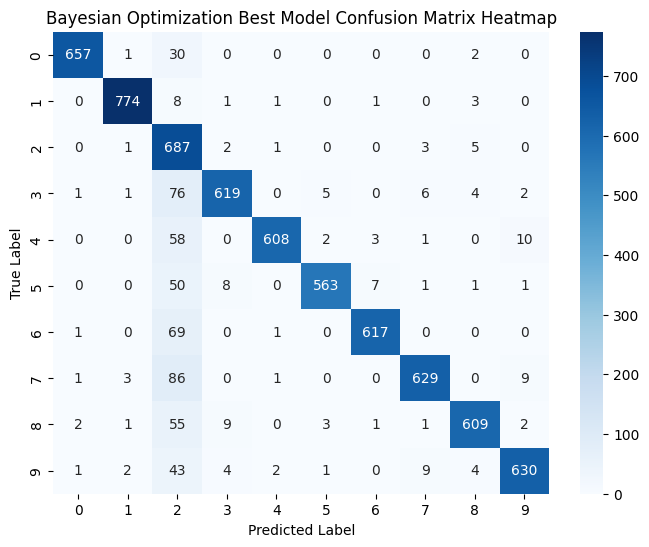

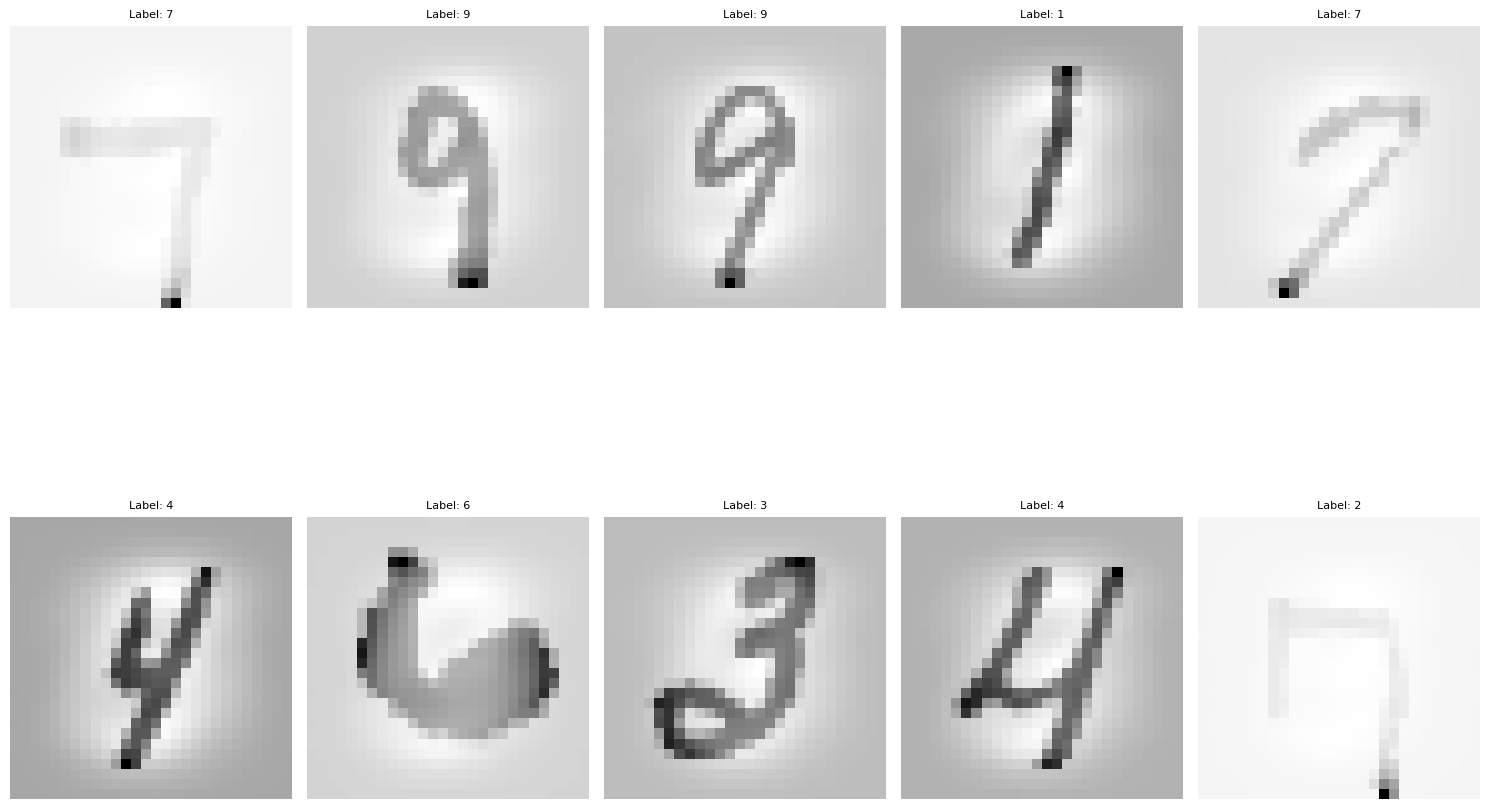

In [14]:
import optuna
# Load and Preprocess Data
X_train_scaled, X_test_scaled, y_train, y_test = load_and_preprocess_data()

# Visualize Some Training Samples
visualize_samples(X_train_scaled, y_train, sample_size=10, title_prefix="Training Sample")

X_train_cpu = cp.asnumpy(X_train_scaled)
y_train_cpu = cp.asnumpy(y_train)

# Perform Hyperparameter Tuning with Bayesian Optimization
best_model_bayes, study = perform_bayesian_optimization(X_train_cpu, y_train_cpu)

# Evaluate Best Model from Bayesian Optimization
evaluate_model(best_model_bayes, X_test_scaled, y_test, title="Bayesian Optimization Best Model")
